# Resale Flat Prices 🏢💀

*Data sourced from [data.gov.sg](https://data.gov.sg/)*

### About the data

The CSVs provided by [data.gov.sg](https://data.gov.sg/) are split into 5 sets.

Prior to March 2012, data is based on the date of approval for the resale transactions. From March 2012 onwards, the data is based on the date of registration for the resale transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from datetime import datetime
from resale_flats import ResaleFlats

data = ResaleFlats()
data.show()


,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,price_per_sqm,date
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01,61 years 04 months,1979,10 TO 12,1,406,5272.73,2017-01-01
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01,60 years 07 months,1978,01 TO 03,2,108,3731.34,2017-01-01
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01,62 years 05 months,1980,01 TO 03,3,602,3910.45,2017-01-01
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01,62 years 01 month,1980,04 TO 06,4,465,3897.06,2017-01-01
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01,62 years 05 months,1980,01 TO 03,5,601,3955.22,2017-01-01


### Resale Flat Prices by Year

Resale flat prices have shown an increasing trend over the 30+ years of available data.

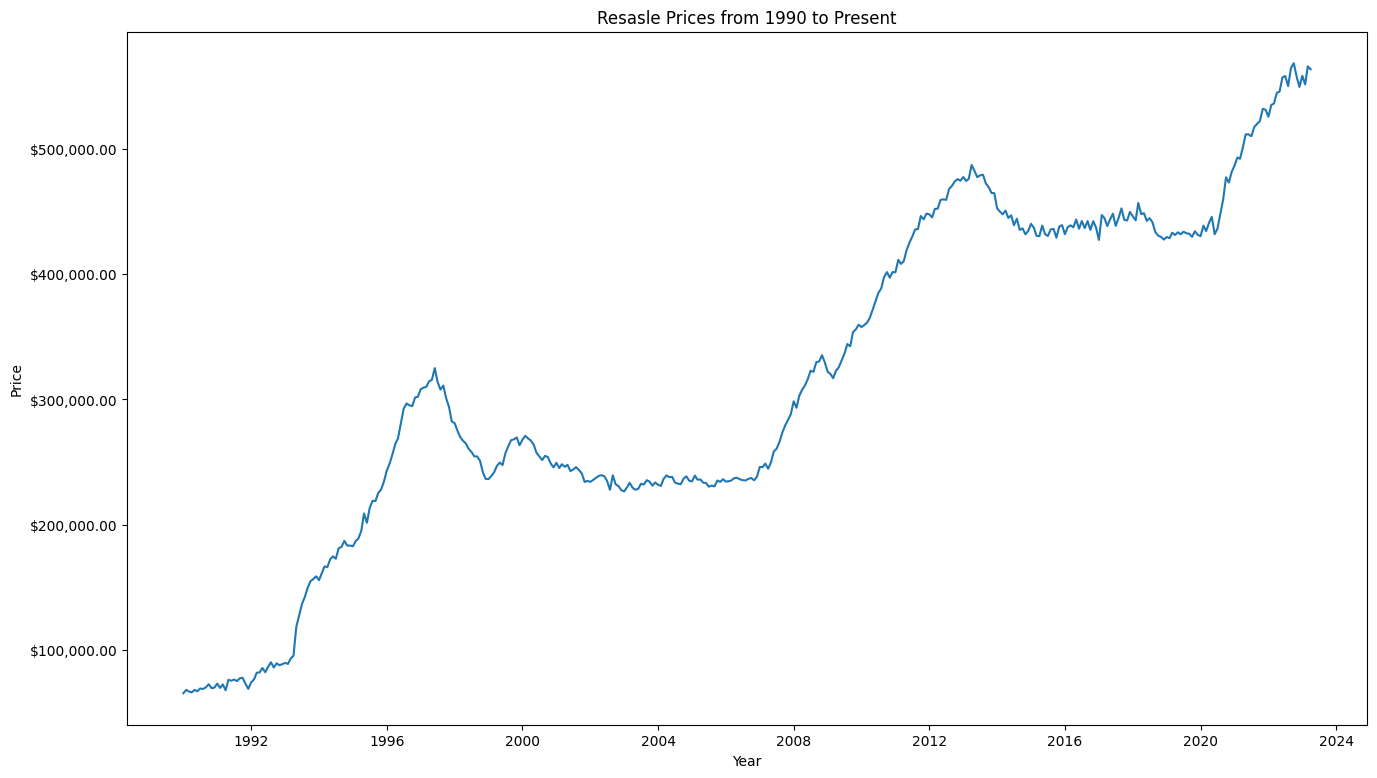

In [2]:
g = sns.lineplot(
    data=data.df,
    x="date",
    y="resale_price",
    errorbar=None
)

g.get_figure().set_size_inches((16, 9), forward=True)

g.set_title("Resasle Prices from 1990 to Present")
g.set_xlabel("Year")
g.set_ylabel("Price")

comma_formatter = ticker.StrMethodFormatter("${x:,.2f}")
g.yaxis.set_major_formatter(comma_formatter)


Beyond overall trends, it is also important to consider the type of property.

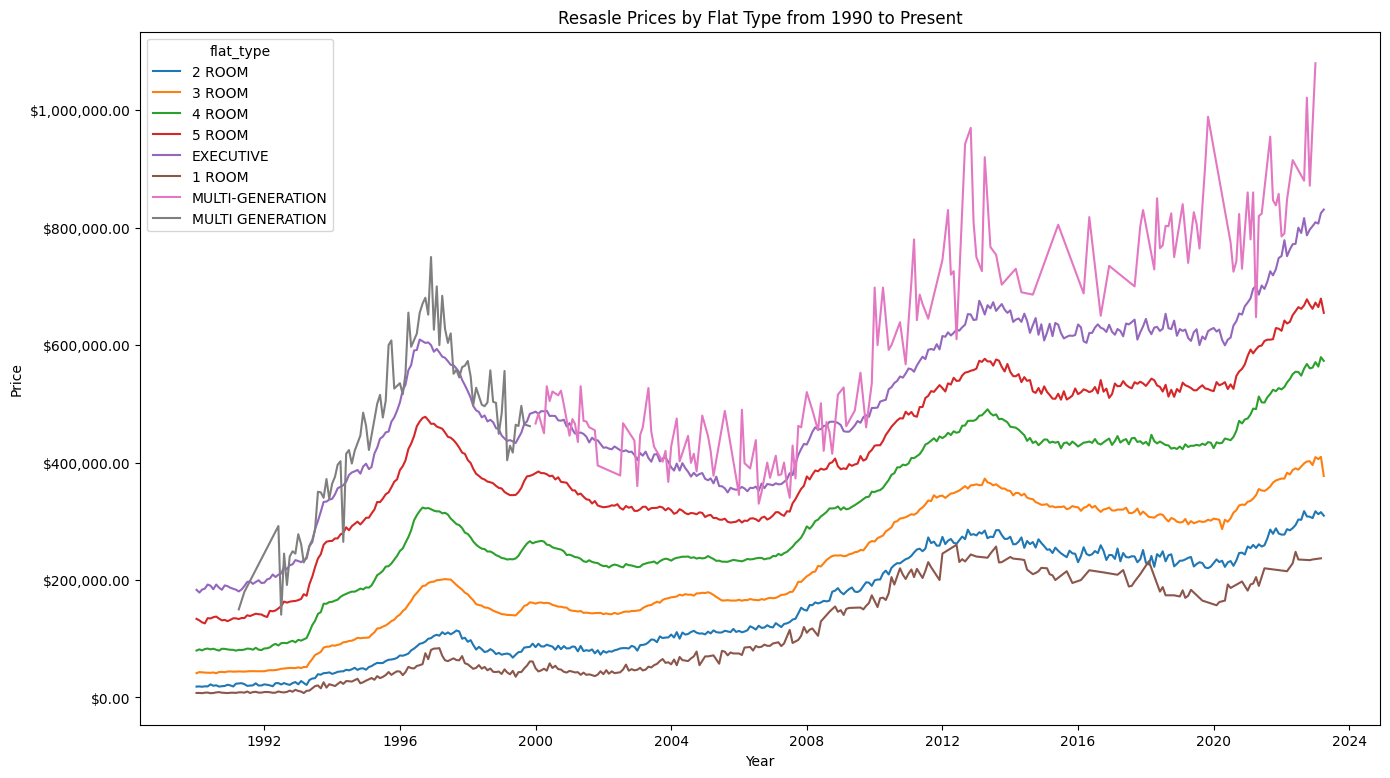

In [3]:
g = sns.lineplot(
    data=data.df,
    x="date",
    y="resale_price",
    hue="flat_type",
    errorbar=None
)

g.get_figure().set_size_inches((16, 9), forward=True)

g.set_title("Resasle Prices by Flat Type from 1990 to Present")
g.set_xlabel("Year")
g.set_ylabel("Price")

g.yaxis.set_major_formatter(comma_formatter)


Tracking price trends may be more useful when applying location filters. For example, below is the price trend for Toa Payoh.

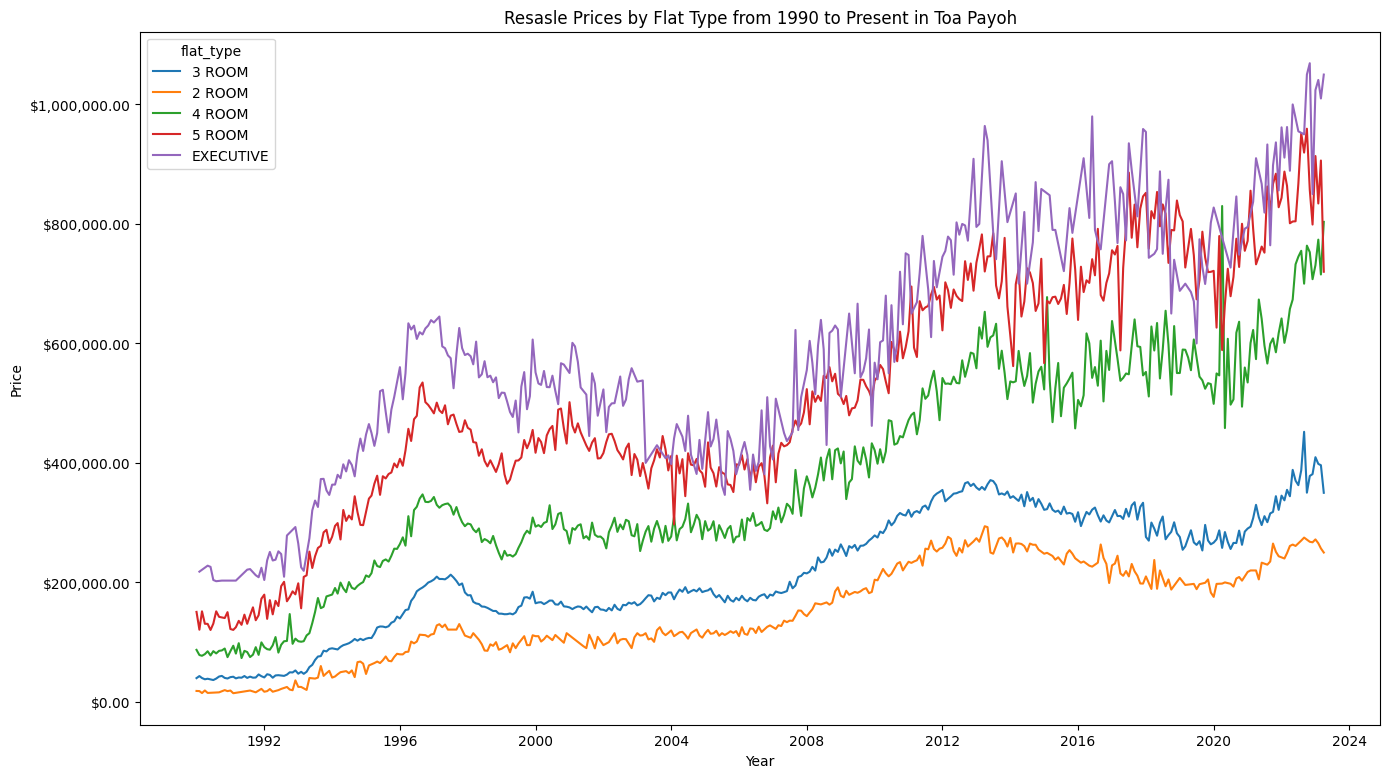

In [4]:
g = sns.lineplot(
    data=data.filter_by_town(["TOA PAYOH"]),
    x="date",
    y="resale_price",
    hue="flat_type",
    errorbar=None
)

g.get_figure().set_size_inches((16, 9), forward=True)

g.set_title("Resasle Prices by Flat Type from 1990 to Present in Toa Payoh")
g.set_xlabel("Year")
g.set_ylabel("Price")

g.yaxis.set_major_formatter(comma_formatter)


Here is the overall trend when applying linear regression. It may not be a good fit, but it provides a rough visualisation for the trends.

In [5]:
# ordinal conversion required to plot datetime as the x-axis
data.reset()
regression_data = data.df[["resale_price", "date"]].copy()
regression_data["date"] = regression_data["date"].apply(
    lambda date: date.toordinal())

# using scipy because linear regression results cannot be extracted from seaborn
slope, intercept, r, p, se = stats.linregress(
    regression_data["date"], regression_data["resale_price"])
eqn = f"y = {slope:.2f}x + {intercept:.2f}"


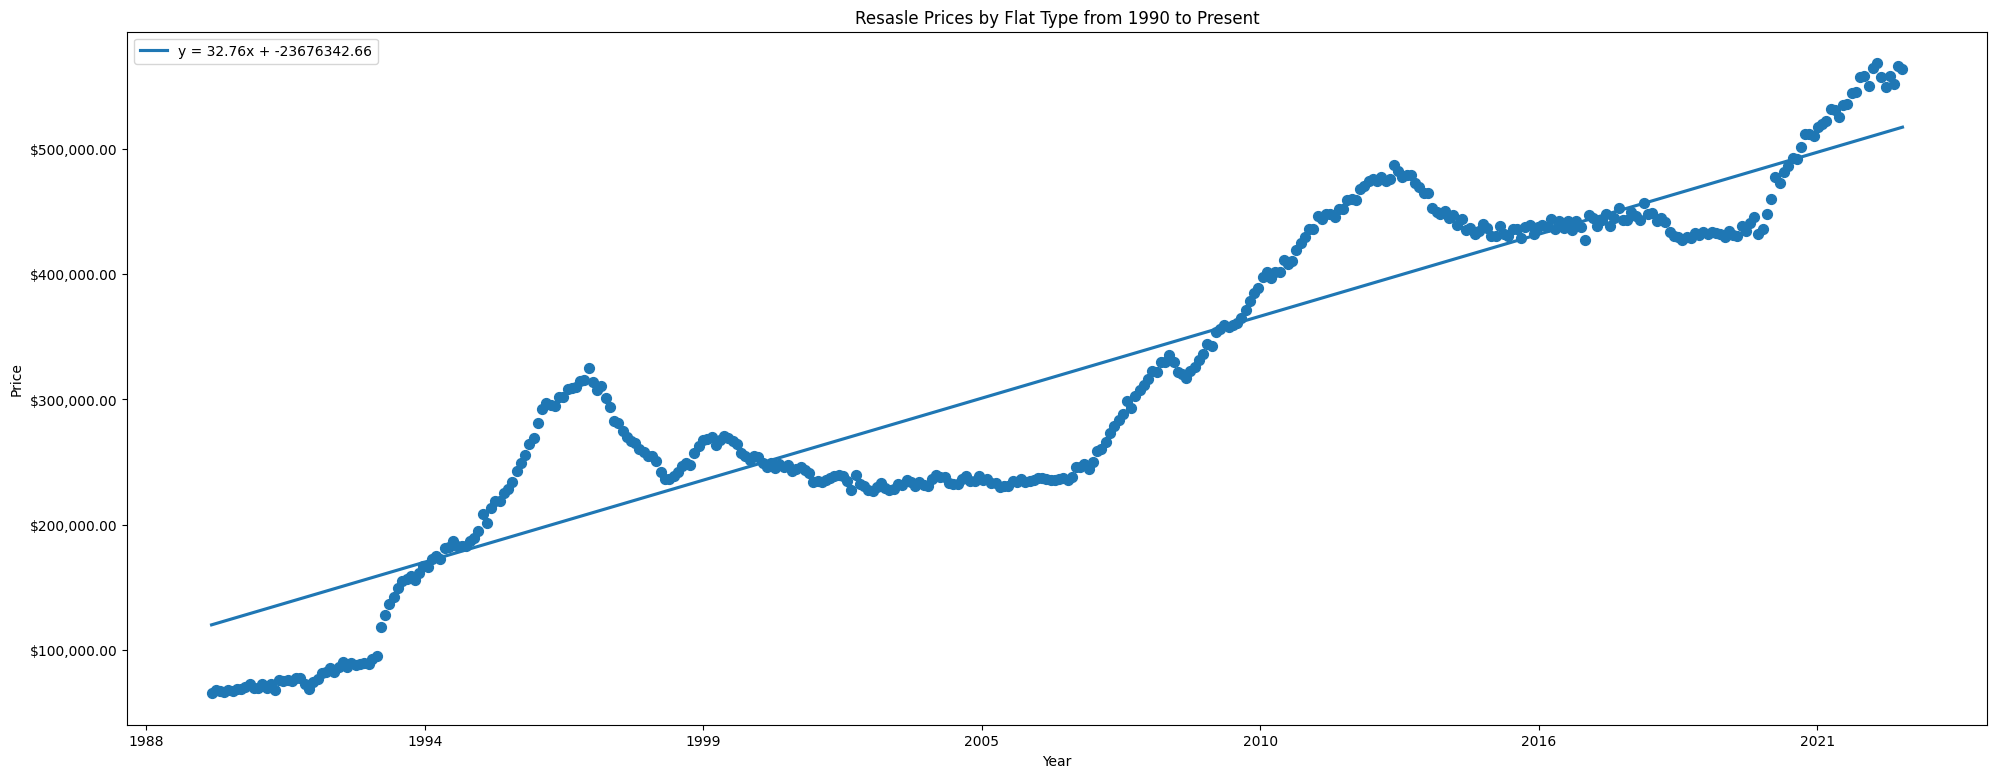

In [6]:
g = sns.regplot(
    data=regression_data,
    x="date",
    y="resale_price",
    x_estimator=np.mean,
    ci=None,
    line_kws={"label": eqn}
)

g.get_figure().set_size_inches((24, 9), forward=True)

# reset tick labels back to years
g.xaxis.set_major_locator(ticker.FixedLocator(g.get_xticks()))
g.set_xticklabels([datetime.fromordinal(
    int(tick)).year for tick in g.get_xticks()])

g.set_title("Resasle Prices by Flat Type from 1990 to Present")
g.set_xlabel("Year")
g.set_ylabel("Price")
g.legend()

g.yaxis.set_major_formatter(comma_formatter)


With the slope obtained, the expected growth can then be calculated. Let's take 10 years as an example.

In [14]:
# ordinal measures number of days since 0001-01-01
# 365 is an approximation of the number of days every year
number_of_years = 10
expected_growth = slope * number_of_years * 365
print(f"Expected growth: ${expected_growth:.2f}")

Expected growth: $119559.51


### Mean Resale Flat Prices by Location (2020 - Present)

A key consideration in the value of the flat is its location. As a demonstration, we will look at 3-room, 4-room and 5-room flats from 2020.

In [8]:
start = datetime(1990, 1, 1)
flat_types = ["3 ROOM", "4 ROOM", "5 ROOM"]

data.reset()
data.filter_by_time(start=start)
data.filter_by_flat_type(flat_types=flat_types)

grouped_data = data.df.groupby(["town", "flat_type"], as_index=False)
mean_prices = grouped_data["resale_price"].mean()
display(mean_prices.head())


,town,flat_type,resale_price
0,ANG MO KIO,3 ROOM,193900.142776
1,ANG MO KIO,4 ROOM,309290.391489
2,ANG MO KIO,5 ROOM,470325.334604
3,BEDOK,3 ROOM,190370.021243
4,BEDOK,4 ROOM,285575.720155


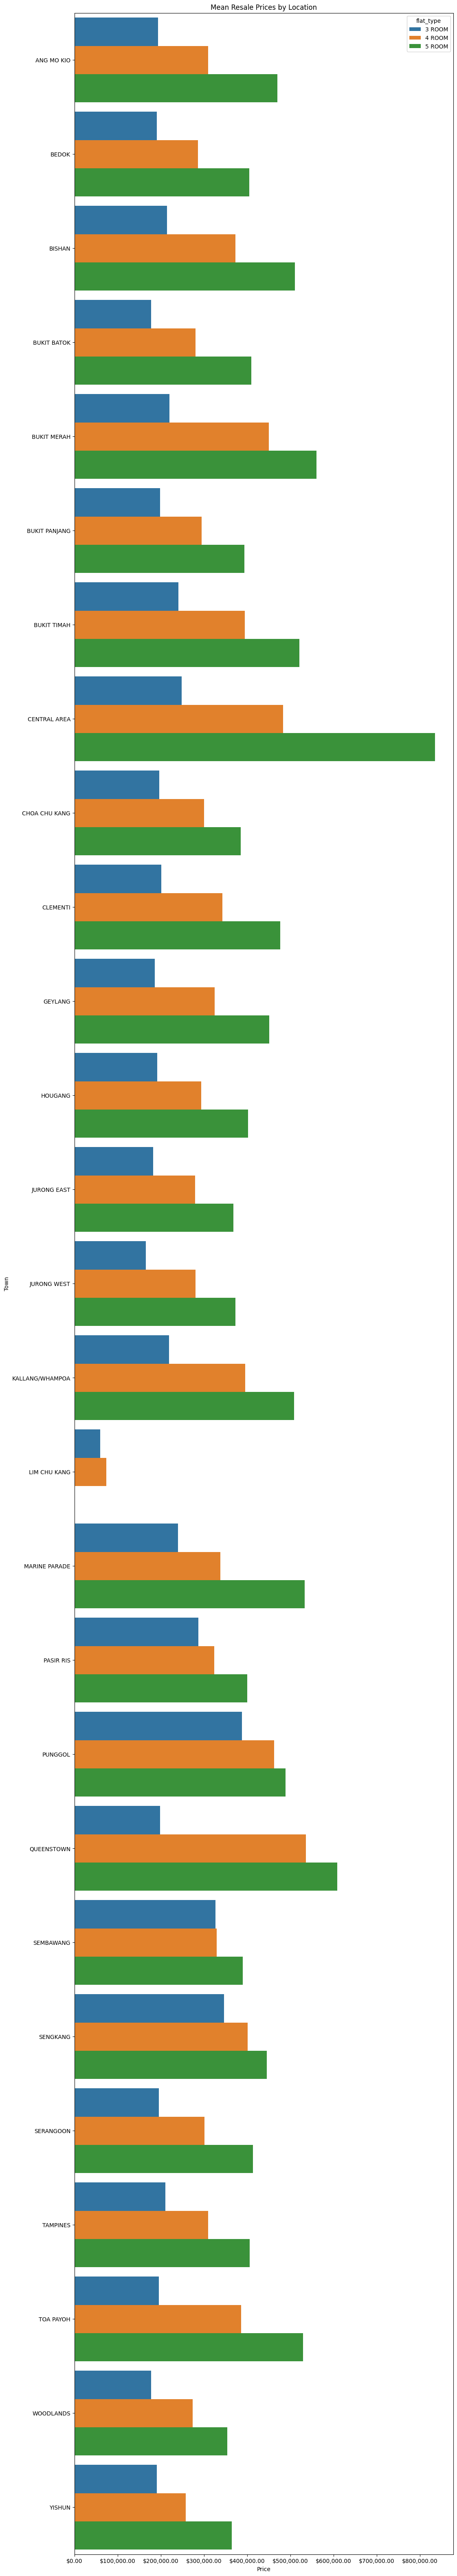

In [9]:
g = sns.barplot(
    data=mean_prices,
    x="resale_price",
    y="town",
    hue="flat_type",
    width=0.9,
)

h = len(data.get_towns()) * 3
g.get_figure().set_size_inches((12, h), forward=True)

g.set_title("Mean Resale Prices by Location")
g.set_xlabel("Price")
g.set_ylabel("Town")

g.xaxis.set_major_formatter(comma_formatter)


Factoring in the floor area could also provide a more complete picture.

,town,flat_type,price_per_sqm
0,ANG MO KIO,3 ROOM,2727.054069
1,ANG MO KIO,4 ROOM,3320.984567
2,ANG MO KIO,5 ROOM,3931.674589
3,BEDOK,3 ROOM,2784.357702
4,BEDOK,4 ROOM,3087.111338


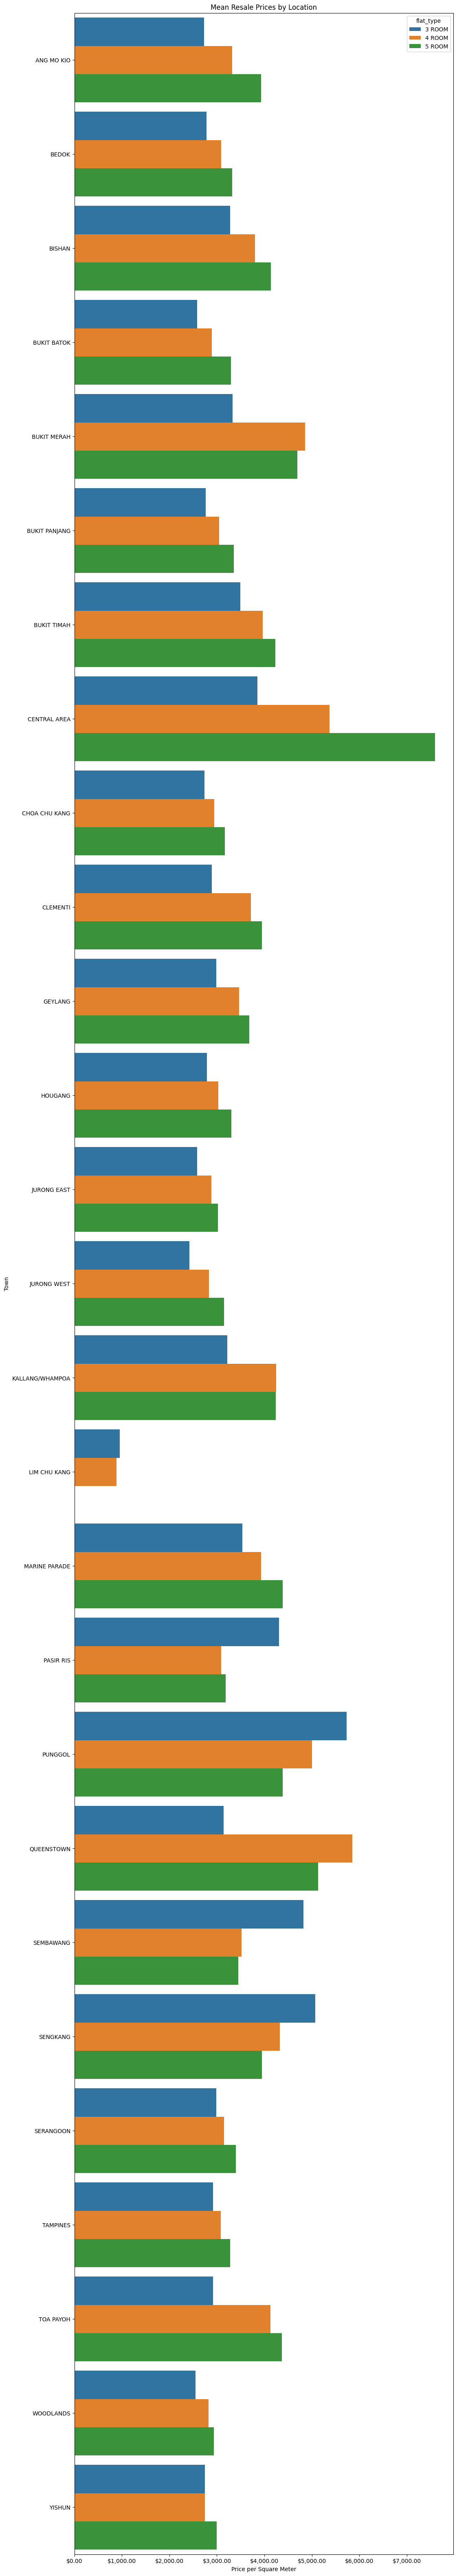

In [11]:
grouped_data = data.df.groupby(["town", "flat_type"], as_index=False)
mean_prices = grouped_data["price_per_sqm"].mean()
display(mean_prices.head())

g = sns.barplot(
    data=mean_prices,
    x="price_per_sqm",
    y="town",
    hue="flat_type",
    width=0.9,
)

h = len(data.get_towns()) * 3
g.get_figure().set_size_inches((12, h), forward=True)

g.set_title("Mean Resale Prices by Location")
g.set_xlabel("Price per Square Meter")
g.set_ylabel("Town")

g.xaxis.set_major_formatter(comma_formatter)